<div style="background-color:#035FCA; color:#19180F; font-size:40px; font-family:Verdana; padding:10px; border: 5px solid #19180F;"> GPT2(Generative Pre-trained Transformer 2) </div>
<div style="background-color:#568FD1; color:#19180F; font-size:30px; font-family:Verdana; padding:10px; border: 5px solid #19180F;"> Architectural Overview.
 </div>
<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;"><br>

It is a language model that utilizes a transformer based architecture and comprises of several key components like Input Embeddings, Encoder layers, Decoder layers and Output Layers.<br>
1. Input Embedding : In this the input text is converted to numerical representations that can be understood by the model. The embedding layer is being deployed for this task which maps each word or token in the input seq to a high dim vector.<br>
2. Encoder layer - GPT2 consists of multiple identical encoder layers stacked over each other. Each encoder layer has two sub layers which are a self attention mechanism and feed forwd network. The self attention mechanism allows the model to weigh the importance of diff words or tokens with inp. seq thereby capturing the dependencies and relationships betw. them. The feed forward network processes the self attn outputs to gen more complex representations.<br>
3. Decoder layer - It follows the encoder layers and has a similar structure as it also consists of self attention and feed forward layers. Just that in this the decoder layer is conditioned on the context from the prev. tokens enabling autoregressive generation. This means the model predicts the next word in the seq based on the context it has learned so far.<br>
4. Output layer - The final layer of GPT2 is a linear transformation followed by a softmax activation function. This layer produces the prob. distribution over the vocab for the next word in the sequence. It alows the model to generate text by sampling from the distribution or choosing the word with the highest probability.<br>
</div>

<div style="background-color:#568FD1; color:#19180F; font-size:30px; font-family:Verdana; padding:10px; border: 5px solid #19180F;"> Architecture Diagram.
 </div>

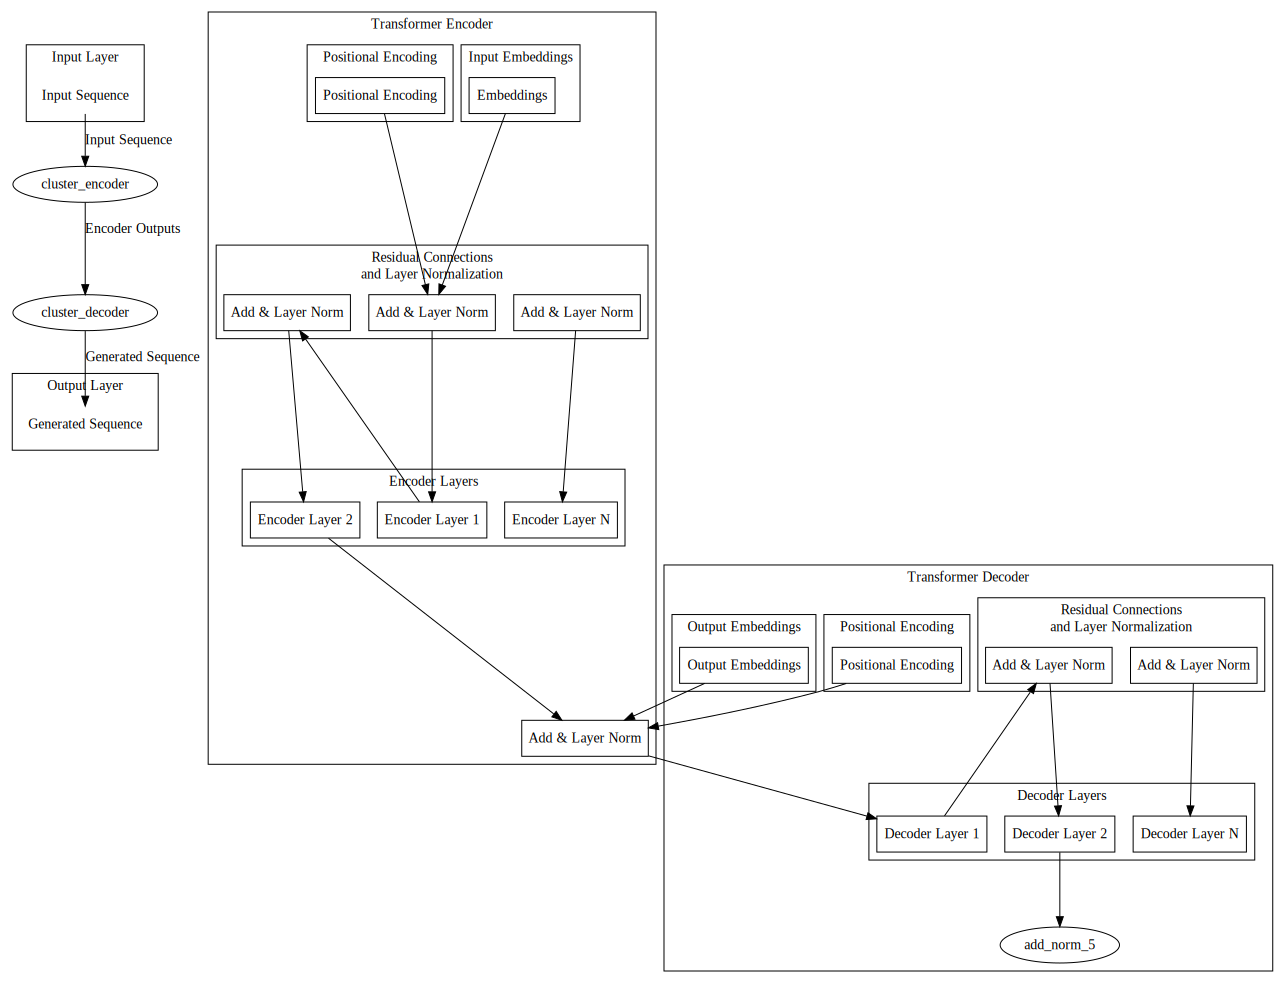

In [18]:
from IPython.display import SVG, display

# Load the SVG file and display it
svg_file = '/kaggle/input/notebook-images/gpt2.svg'
display(SVG(filename=svg_file))

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">Importing modules</div>

In [2]:
import torch
from torch.utils.data import DataLoader
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AdamW
from datasets import load_dataset


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">This snippet imports the necessary libraries and modules for the code. We import torch for PyTorch functionality, DataLoader for creating data loaders, GPT2LMHeadModel and GPT2Tokenizer from transformers for the GPT-2 model and tokenizer, and AdamW for the optimizer. We also import load_dataset from datasets to load the Kaggle dataset.
</div>

In [3]:
# Load and preprocess the dataset
dataset = load_dataset("csv", data_files="/kaggle/input/all-the-news/articles1.csv")
text_samples = dataset["train"]["content"]


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-4efec2533fba91d5/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">This code snippet loads and preprocesses the dataset. We use the `load_dataset` function from the `datasets` library to load the dataset from the CSV file. We then extract the text samples from the training split of the dataset and store them in the `text_samples` variable.
</div>

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'id', 'title', 'publication', 'author', 'date', 'year', 'month', 'url', 'content'],
        num_rows: 50000
    })
})

In [5]:
# Initialize the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained('gpt2')

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">In this snippet, we initialize the GPT-2 tokenizer and model. We use `GPT2Tokenizer.from_pretrained` to load the GPT-2 tokenizer from the 'gpt2' pre-trained model. Similarly, we use `GPT2LMHeadModel.from_pretrained` to load the GPT-2 model. We also add the pad token as `eos_token`</div>

In [6]:
# Tokenize and encode the dataset
def tokenize_function(example):
    return tokenizer(example["content"], truncation=True, max_length=512, padding="max_length")

tokenized_dataset = dataset.map(tokenize_function, batched=True)



  0%|          | 0/50 [00:00<?, ?ba/s]

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">This code snippet tokenizes and encodes the dataset using the tokenizer. We define a `tokenize_function` that takes an example as input and applies the tokenizer to the 'content' field of the example. The tokenizer tokenizes the text, truncates it to a maximum length of 512 tokens, and pads the sequences to the same length using the `padding="max_length"` argument. Finally, we apply the `tokenize_function` to the dataset using the `map` method, with `batched=True` to process the examples in batches.
</div>

In [7]:
def collate_fn(batch):
    input_ids = [item["input_ids"] for item in batch]
    attention_masks = [item["attention_mask"] for item in batch]
    labels = [item["input_ids"] for item in batch]

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(labels)

    # Pad sequences to the same length
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True)
    attention_masks = torch.nn.utils.rnn.pad_sequence(attention_masks, batch_first=True)
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return {
        "input_ids": input_ids,
        "attention_mask": attention_masks,
        "labels": labels,
    }

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
<br>The `collate_fn` function described here is a custom collate function for a PyTorch DataLoader. It takes a batch of data samples and processes them to ensure that sequences within the batch have the same length, suitable for training a language model like GPT-2.<br>
<br>
Here is a step-by-step description of the `collate_fn` function:<br>
    
1. Extracts the `"input_ids"`, `"attention_mask"`, and `"labels"` from each item in the batch.<br>

2. Converts the extracted lists into tensors using `torch.tensor()`. This step is necessary because `pad_sequence` expects tensors as input.<br>

3. Applies `torch.nn.utils.rnn.pad_sequence()` to the `input_ids`, `attention_masks`, and `labels` tensors to pad the sequences to the same length. The `pad_sequence` function pads sequences with zeros along the batch dimension, ensuring that all sequences in the batch have the same length.<br>

4. Returns a dictionary containing the padded `input_ids`, `attention_mask`, and `labels` tensors.<br>
<br></div>

In [8]:
# Prepare the data for training
train_dataset = tokenized_dataset["train"]
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True,collate_fn=collate_fn)


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
This snippet prepares the tokenized dataset for training. We extract the 'train' split of the tokenized dataset and assign it to the `train_dataset` variable. Then, we create a data loader using `DataLoader`, passing the `train_dataset`, setting the `batch_size` to 4 and enabling shuffling of the data with `shuffle=True`. We didn't mention the collate_fn here since tokenizer already takes care of max_length.</div>


In [9]:
# Set up the training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
This code snippet sets up the training parameters. It checks if a GPU is available and assigns the appropriate device to the `device` variable. Then, we move the model to the selected device using the `to(device)` method. We also initialize the AdamW optimizer with the model parameters and a learning rate of `1e-5`.</div>


In [10]:
for batch in train_dataloader:
    print(batch)
    break

{'input_ids': tensor([[21793,   220,   851,  ..., 12069,   416,  3899],
        [31567, 43535, 14015,  ...,   447,   247,    82],
        [31632,   447,   247,  ...,   286,   262,   995],
        [ 2215,   257,  4744,  ..., 50256, 50256, 50256]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([[21793,   220,   851,  ..., 12069,   416,  3899],
        [31567, 43535, 14015,  ...,   447,   247,    82],
        [31632,   447,   247,  ...,   286,   262,   995],
        [ 2215,   257,  4744,  ..., 50256, 50256, 50256]])}


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
In this code snippet, We perform a sanity check of the dataloader.</div>

In [11]:
# Training loop
model.train()
num_epochs=1
for epoch in range(num_epochs):
    for step,batch in enumerate(train_dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["input_ids"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        if step%400==0:
            print("Step-{},Loss-{}".format(step,loss.item()))
            break
        loss.backward()
        optimizer.step()


Step-0,Loss-5.218831539154053


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
This code snippet defines the training loop. We set the model to training mode using `model.train()`. Then, for each epoch in the specified number of epochs, we iterate over the batches in the `train_dataloader`. Inside the loop, we move the input tensors (`input_ids`, `attention_mask`, and `labels`) to the appropriate device. We zero the gradients with `optimizer.zero_grad()`, forward pass the inputs through the model, compute the loss, perform backward propagation with `loss.backward()`, and update the model parameters using `optimizer.step()`.</div>


In [12]:
# Save the trained model
output_path = '/kaggle/working/GPT2-model.pth'
torch.save(model.state_dict(), output_path)


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
This code snippet saves the trained model to a file.The `state_dict()` method of the model returns a dictionary containing the model's parameters, which is then saved using `torch.save()`.
</div>

In [13]:
# Load the trained model
model_path = '/kaggle/working/GPT2-model.pth'
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
This code snippet loads the trained model from the saved checkpoint for further inferencing.</div>

In [14]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
# Set the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
The code snippet abve sets the device to GPU if available else use the CPU. It then moves the model to device. It also sets the model to evaluation mode.Initialization of tokenizer is done at the last.</div>

In [15]:
# Generate text
prompt = "Once upon a time"
input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
output = model.generate(input_ids, max_length=100, num_return_sequences=1)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">

The code snippet defined above does the following :<br>
   - Set the `prompt` variable to the desired starting text.<br>
   - Encode the prompt using the tokenizer and convert it to a PyTorch tensor.<br>
   - Generate text using the trained model by calling `model.generate()`. Adjust the `max_length` parameter to control the length of the generated text, and `num_return_sequences` to control the number of different texts generated.<br>
<br>
</div>


In [16]:
# Decode and print the generated text
for i, generated in enumerate(output):
    text = tokenizer.decode(generated, skip_special_tokens=True)
    print(f"Generated text {i+1}: {text}")

Generated text 1: Once upon a time, the world was a place of great beauty and great danger. The world was a place of great danger, and the world was a place of great danger. The world was a place of great danger, and the world was a place of great danger. The world was a place of great danger, and the world was a place of great danger. The world was a place of great danger, and the world was a place of great danger. The world was a place of great


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
The code snippet decodes the generated tensor into readable text using the tokenizer's `decode()` function and prints out the generated text.</div>

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
Conclusion<br>
We trained the model on the corpus for 400 steps of Epoch 0, only ! You can train more to expect much better accuracy ! :D <br>
    </div>